## PyTorch conv2d

In [1]:
import torch
rand_input = torch.randn(20, 16, 50, 100)

In [5]:
# With square kernels and equal stride
m = torch.nn.Conv2d(16, 33, 3, stride=2)
output = m(rand_input)
print(output.shape)

torch.Size([20, 33, 24, 49])


In [7]:
# non-square kernels and unequal stride and with padding
m = torch.nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2))
output = m(rand_input)
print(output.shape)

torch.Size([20, 33, 28, 100])


In [8]:
# non-square kernels and unequal stride and with padding and dilation
m = torch.nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2), dilation=(3, 1))
output = m(rand_input)
print(output.shape)

torch.Size([20, 33, 26, 100])


## PyTorch pool2d

In [10]:
# pool of square window of size=3, stride=2
m = torch.nn.MaxPool2d(3, stride=2)
output = m(rand_input)
print(output.shape)

torch.Size([20, 16, 24, 49])


In [11]:
# pool of non-square window
m = torch.nn.MaxPool2d((3, 2), stride=(2, 1))
output = m(rand_input)
print(output.shape)

torch.Size([20, 16, 24, 99])


## TensorFlow conv2d

In [33]:
import tensorflow as tf
rand_input = tf.random.normal([20, 50, 100, 16])

In [34]:
# With square kernels and equal stride
m = tf.keras.layers.Conv2D(33, 3, strides=2)
output = m(rand_input)
print(output.shape)

(20, 24, 49, 33)


In [35]:
# non-square kernels and unequal stride and with padding
p = tf.keras.layers.ZeroPadding2D((4, 2))
m = tf.keras.layers.Conv2D(33, (3, 5), strides=(2, 1))
output = m(p(rand_input))
print(output.shape)

(20, 28, 100, 33)


In [36]:
# non-square kernels and equal stride and with padding and dilation
p = tf.keras.layers.ZeroPadding2D((4, 2))
m = tf.keras.layers.Conv2D(33, (3, 5), strides=(1, 1), dilation_rate=(3, 1))
output = m(p(rand_input))
print(output.shape)

(20, 52, 100, 33)


## TensorFlow pool2d

In [37]:
# pool of square window of size=3, strides=2
m = tf.keras.layers.MaxPooling2D(3, strides=2)
output = m(rand_input)
print(output.shape)

(20, 24, 49, 16)


In [38]:
# pool of non-square window
m = tf.keras.layers.MaxPooling2D((3, 2), strides=(2, 1))
output = m(rand_input)
print(output.shape)

(20, 24, 99, 16)


# CNN in PyTorch

## 1. Loading and normalizing CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.

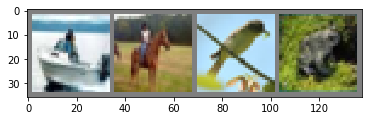

 ship horse  bird  frog


In [74]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolutional Neural Network

In [80]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 3. Define a Loss function and optimizer

In [81]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [82]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.105
[1,  4000] loss: 1.707
[1,  6000] loss: 1.528
[1,  8000] loss: 1.455
[1, 10000] loss: 1.350
[1, 12000] loss: 1.296
[2,  2000] loss: 1.194
[2,  4000] loss: 1.176
[2,  6000] loss: 1.160
[2,  8000] loss: 1.119
[2, 10000] loss: 1.086
[2, 12000] loss: 1.053
Finished Training


## 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

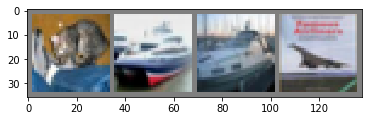

GroundTruth:    cat  ship  ship plane


In [83]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [84]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


The results seem pretty good.

Let us look at how the network performs on the whole dataset.

In [85]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 64 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:

In [86]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 62 %
Accuracy of   car : 72 %
Accuracy of  bird : 47 %
Accuracy of   cat : 46 %
Accuracy of  deer : 68 %
Accuracy of   dog : 56 %
Accuracy of  frog : 63 %
Accuracy of horse : 62 %
Accuracy of  ship : 85 %
Accuracy of truck : 77 %


## 6. Check the learned filters

Now we can take a look of what features exactly do we learn from CIFAR10.

In [87]:
import math
import matplotlib.pyplot as plt

def sigmoid(x: np.array):
    return 1 / (1 + np.exp(-x))

def plot_conv_kernel(w: np.ndarray, labels: list = None, is_pytorch: bool=True):
    """
    Plots the kernel weights as a grid of images.
    The input's shape must be (height, weight, input channels, output channels).
    If the input is 3-dimensional, it's assumed to have 1 output channel.
    
    Before plotting, this function rescales the kernel
    by making its std = 1, so that pixel values are significantly different.
    Finally, it applies sigmoid activation to fit the weights into (0, 1) range.
    
    :param w: the kernel to plot
    :param labels: optional list of labels for each output channel
    """
    
    if is_pytorch:
        w = np.moveaxis(w, [0, 1, 2, 3], [3, 2, 0, 1])
        print(w.shape)
    
    if len(w.shape) == 3:
        w = np.expand_dims(w, -1)
    elif len(w.shape) != 4:
        raise Exception('Kernel must be either 3- or 4-dimensional array')
        
    cols = math.ceil(math.sqrt(w.shape[3]))
    rows = math.ceil(w.shape[3] / cols)

    if labels is None:
        labels = range(w.shape[3])

    plt.figure(figsize=[2 * cols, 2 * rows])
    for i in range(w.shape[3]):
        wt = w[:, :, :, i]

        # Rescaling so that sigmoid is saturated.
        wt = wt / wt.std()
        wt = sigmoid(wt)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(wt, vmin=0, vmax=1)
        plt.title(labels[i])
        plt.xticks([])
        plt.yticks([])

    plt.show()

(5, 5, 3, 32)


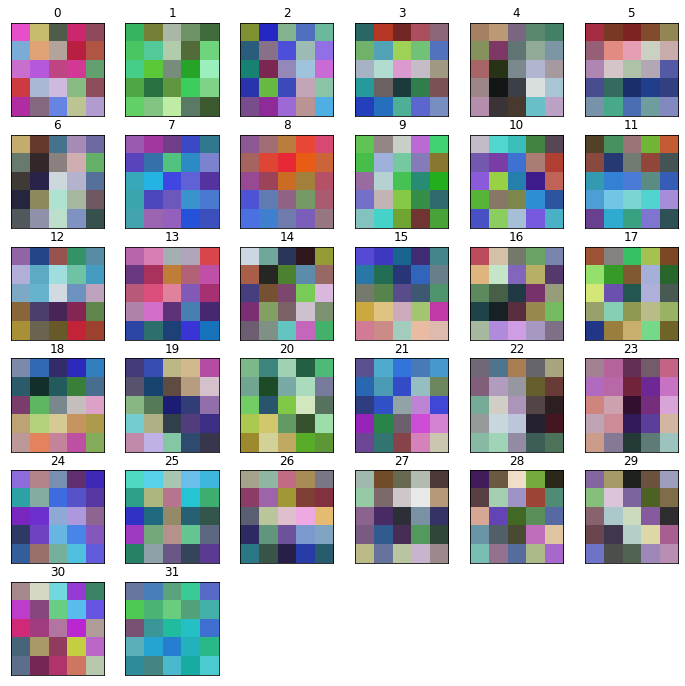

In [88]:
plot_conv_kernel(net.conv1.weight.detach().numpy())

# CNN in TensorFlow

## Import TensorFlow

In [89]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

## Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [90]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

## Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.


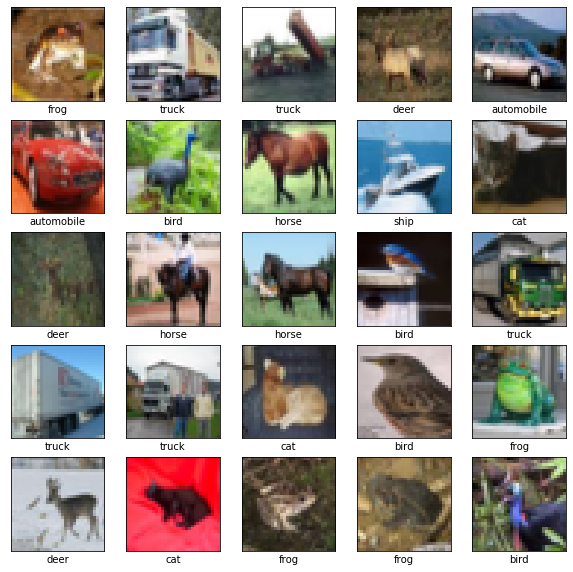

In [91]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure our CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to our first layer.


In [92]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [93]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

## Add Dense layers on top
To complete our model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs and a softmax activation.

In [94]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [95]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

As you can see, our (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

## Compile and train the model

In [96]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 27s 17ms/step - loss: 1.4907 - accuracy: 0.4549 - val_loss: 1.2093 - val_accuracy: 0.5673
Epoch 2/10
1563/1563 [==============================] - 26s 17ms/step - loss: 1.1386 - accuracy: 0.5979 - val_loss: 1.0524 - val_accuracy: 0.6298
Epoch 3/10
1563/1563 [==============================] - 26s 17ms/step - loss: 0.9952 - accuracy: 0.6488 - val_loss: 1.0088 - val_accuracy: 0.6442
Epoch 4/10
1563/1563 [==============================] - 26s 17ms/step - loss: 0.9006 - accuracy: 0.6844 - val_loss: 0.9360 - val_accuracy: 0.6804
Epoch 5/10
1563/1563 [==============================] - 27s 17ms/step - loss: 0.8220 - accuracy: 0.7109 - val_loss: 0.8665 - val_accuracy: 0.6954
Epoch 6/10
1563/1563 [==============================] - 27s 18ms/step - loss: 0.7685 - accuracy: 0.7320 - val_loss: 0.8878 - val_accuracy: 0.6937
Epoch 7/10
1563/1563 [==============================] - 26s 17ms/step - loss: 0.7157 - accuracy: 0.7494 - val_loss: 0.8543 -

## Evaluate the model

313/313 - 1s - loss: 0.8832 - accuracy: 0.7108


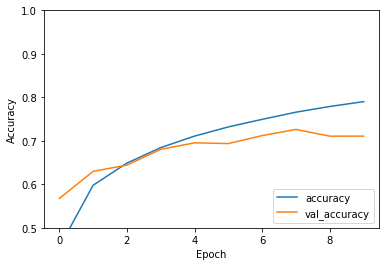

In [97]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

## Check the learned filters

Now we can take a look of what features exactly do we learn from CIFAR10.

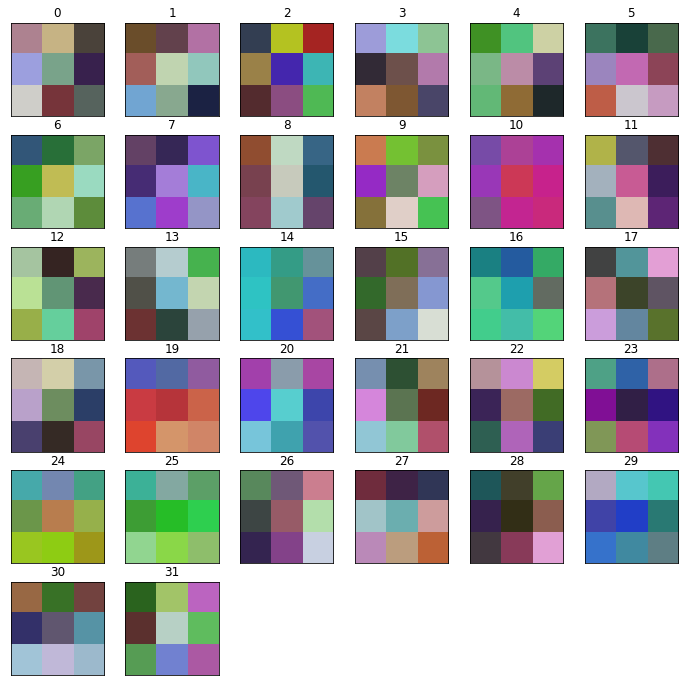

In [109]:
plot_conv_kernel(model.weights[0].numpy(), is_pytorch=False)